# Task IX: Kolmogorov-Arnold Network 
- Implement a classical Kolmogorov-Arnold Network using basis-splines or some other KAN architecture and apply it to MNIST. 
- Show its performance on the test data. 
- Comment on potential ideas to extend this classical KAN architecture to a quantum KAN and sketch out the architecture in detail. 

# KAN using B-Splines and Performance

## KAN Using B-Splines

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
'''
- torch: The core PyTorch library for building and training neural networks.
- torch.nn: Provides modules for defining layers and activation functions.
- torch.optim: Contains optimization algorithms like Adam.
- torchvision: Used for loading and preprocessing datasets like MNIST.
- DataLoader: Helps in batching and shuffling the dataset during training and testing.
'''

''' Load and preprocess MNIST '''
'''
- transforms.Compose:
  - Combines multiple preprocessing steps.
  - ToTensor: Converts images to tensors with pixel values in the range [0, 1].
  - Normalize: Normalizes the pixel values to have a mean of 0.1307 and a standard deviation of 0.3081. 
    (These values are specific to the MNIST dataset.)

- torchvision.datasets.MNIST:
  - Downloads the MNIST dataset and applies the transformations.

- DataLoader:
  - Creates iterable objects for batching and shuffling the dataset.
  - batch_size=64: Each batch contains 64 images.
  - shuffle=True: Randomizes the order of the training data.
'''
def get_mnist_loaders(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    train_set = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

''' Define a Spline Activation Function '''
'''
- Purpose:
  - Implements a custom activation function (rather than using a standard one like ReLU or Sigmoid) using linear interpolation between knots.
    (knots are points in the input space where the function's output is defined)
  - The knots and their corresponding values are learnable parameters.

- How It Works:
  1. Clamp Input: Ensures the input values are within the range of the knots.
  2. Find Knot Indices: Uses torch.searchsorted to find the indices of the knots that bound each input value.
  3. Linear Interpolation:
     - Computes the interpolated value using the formula:
       y = y_0 + t  (y_1 - y_0)
       where t = (x - x_0) / (x_1 - x_0)
'''
class SplineActivation(nn.Module):
    def __init__(self, num_knots=10):
        super().__init__()
        self.knots = nn.Parameter(torch.linspace(-1, 1, num_knots))  # Knot positions
        self.values = nn.Parameter(torch.randn(num_knots))  # Values at knots
    
    def forward(self, x):
        # Perform linear interpolation manually
        x_clamped = torch.clamp(x, min=self.knots[0].item(), max=self.knots[-1].item())
        indices = torch.searchsorted(self.knots, x_clamped) - 1
        indices = torch.clamp(indices, 0, len(self.knots) - 2)
        
        x0 = self.knots[indices]
        x1 = self.knots[indices + 1]
        y0 = self.values[indices]
        y1 = self.values[indices + 1]
        
        # Linear interpolation
        t = (x_clamped - x0) / (x1 - x0)
        return y0 + t * (y1 - y0)

''' Define the KAN Model '''
'''
- Architecture:
  - Input Layer: Accepts flattened MNIST images of size 784 (28x28).
  - Hidden Layer: A fully connected layer with 128 neurons.
  - Spline Activation: Applies the custom spline activation function.
  - Output Layer: A fully connected layer with 10 neurons (one for each digit class).

- Forward Pass:
  - The input is flattened, passed through the layers, and activated using the spline function.
'''
class KAN(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.spline1 = SplineActivation()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.spline1(self.fc1(x))
        x = self.fc2(x)
        return x

''' Training Function '''
''' 
- Steps:
  1. Set Up:
     - Define the loss function (CrossEntropyLoss) and optimizer (Adam).
     - Set the model to training mode using model.train().
  2. Training Loop:
     - For each batch:
       - Perform a forward pass, compute the loss, backpropagate, and update the parameters.
  3. Print Loss:
     - Print the average loss for each epoch.
'''
def train_kan(model, train_loader, epochs=5, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

''' Evaluate the Model '''
def test_kan(model, test_loader):
    model.eval() 
    ''' To disable dropout and batch normalization layers during evaluation '''
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Main Execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_mnist_loaders()
kan_model = KAN().to(device)
train_kan(kan_model, train_loader)
test_kan(kan_model, test_loader)

Epoch 1, Loss: 0.8963
Epoch 2, Loss: 0.5867
Epoch 3, Loss: 0.4510
Epoch 4, Loss: 0.3749
Epoch 5, Loss: 0.3241
Test Accuracy: 90.59%


In [3]:
# Recreate the model architecture
loaded_model = KAN().to(device)

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load("kan_model.pth"))
loaded_model.eval()  # Set the model to evaluation mode
print("Model loaded from kan_model.pth")

Model loaded from kan_model.pth


## Performance

Model loaded and ready for predictions.


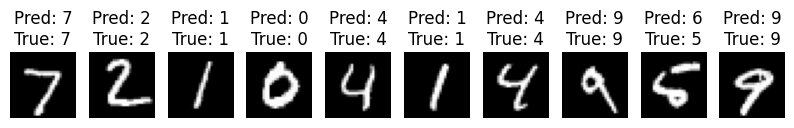

In [2]:
import matplotlib.pyplot as plt

# Load the trained model
kan_model = KAN().to(device)
kan_model.load_state_dict(torch.load("kan_model.pth"))
kan_model.eval()  # Set the model to evaluation mode
print("Model loaded and ready for predictions.")

# Get a batch of test images
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Make predictions
outputs = kan_model(images)
_, predicted = torch.max(outputs, 1)  # Get the predicted class

# Visualize the predictions
def plot_predictions(images, labels, predicted, num_images=10):
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].cpu().view(28, 28), cmap="gray")  # Reshape to 28x28 for visualization
        plt.title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}")
        plt.axis("off")
    plt.show()

# Plot the first 5 predictions
plot_predictions(images, labels, predicted, num_images=10)

# Quantuam - KAN

### **Extending the Classical KAN to a Quantum KAN**

A **Quantum Kolmogorov-Arnold Network (QKAN)** can leverage the principles of quantum computing to enhance the classical KAN architecture. Quantum computing provides unique advantages, such as the ability to process high-dimensional data efficiently, exploit quantum parallelism, and represent complex functions with fewer parameters. Similar work has been done in the qiskit library for quantam machine leaning (for classification task).


### **Key Ideas for Extending KAN to QKAN**

1. Quantum Basis Functions
2. Quantum Feature Encoding
3. Quantum Layers
4. Hybrid Quantum-Classical Architecture
5. Quantum Measurement
  

### **Proposed Quantum KAN Architecture**

#### **1. Input Layer**
- Classical to Quantum Encoding:
  - Encode the input data (e.g., MNIST images) into quantum states using techniques like:
    - Amplitude Encoding: Encode pixel intensities into the amplitudes of quantum states.
    - Angle Encoding: Encode pixel intensities into the rotation angles of qubits.

#### **2. Quantum Basis Layer**
-  Replace the classical basis functions (e.g., splines) with parameterized quantum circuits (PQCs) (acting as a quantum basis function), mapping input data to a quantum state and performing transformations difficult to replicate in classical architecture.
- Each PQC applies a series of quantum gates (e.g., rotations, entanglements) to transform the input quantum state.
- The parameters of the gates are trainable

#### **3. Quantum Feature Extraction**
- Introduce quantum layers that perform transformations on the quantum states using quantum gates.
- Apply multiple quantum layers to extract features from the quantum states.
- Use entanglement to capture correlations between different parts of the input data.
- Quantum layers can extract complex features, while classical layers can process these features for tasks like classification.


#### **4. Measurement**
- After processing the data in the quantum layers, perform measurements to extract classical information, which will then be passed to classical layers for further processing.


#### **5. Classical Output Layer**
- Use a classical fully connected layer to process the measured values and produce the final output (e.g., class probabilities for MNIST).


### **Sketch of the Architecture**



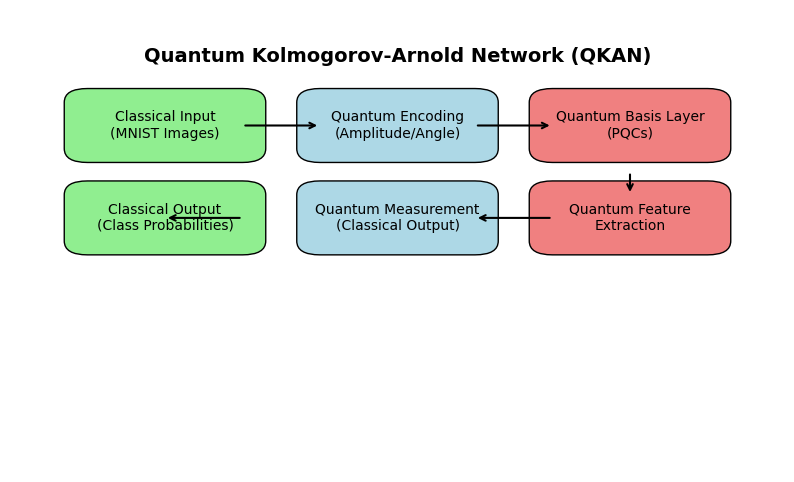

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

def draw_box(ax, x, y, width, height, text, color="lightblue"):
    """Draws a box with text."""
    box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.3", edgecolor="black", facecolor=color)
    ax.add_patch(box)
    ax.text(x + width / 2, y + height / 2, text, ha="center", va="center", fontsize=10)

def draw_arrow(ax, x1, y1, x2, y2):
    """Draws an arrow between two points."""
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1), arrowprops=dict(arrowstyle="->", lw=1.5))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis("off")

# Draw the components of the QKAN
# 1. Input Layer
draw_box(ax, 1, 7, 2, 1, "Classical Input\n(MNIST Images)", color="lightgreen")

# 2. Classical-to-Quantum Encoding
draw_box(ax, 4, 7, 2, 1, "Quantum Encoding\n(Amplitude/Angle)", color="lightblue")
draw_arrow(ax, 3, 7.5, 4, 7.5)

# 3. Quantum Basis Layer
draw_box(ax, 7, 7, 2, 1, "Quantum Basis Layer\n(PQCs)", color="lightcoral")
draw_arrow(ax, 6, 7.5, 7, 7.5)

# 4. Quantum Feature Extraction
draw_box(ax, 7, 5, 2, 1, "Quantum Feature\nExtraction", color="lightcoral")
draw_arrow(ax, 8, 6.5, 8, 6)

# 5. Measurement
draw_box(ax, 4, 5, 2, 1, "Quantum Measurement\n(Classical Output)", color="lightblue")
draw_arrow(ax, 7, 5.5, 6, 5.5)

# 6. Classical Output Layer
draw_box(ax, 1, 5, 2, 1, "Classical Output\n(Class Probabilities)", color="lightgreen")
draw_arrow(ax, 3, 5.5, 2, 5.5)  # Corrected arrow direction: pointing into the last box

# Add labels for clarity
ax.text(5, 9, "Quantum Kolmogorov-Arnold Network (QKAN)", fontsize=14, ha="center", va="center", fontweight="bold")

# Show the diagram
plt.show()



### **Advantages of Quantum KAN**
1. **Higher Expressivity**:
   - Quantum circuits can represent complex functions more efficiently than classical networks.

2. **Dimensionality Reduction**:
   - Quantum systems can encode high-dimensional data into fewer qubits, reducing the computational complexity.

3. **Quantum Parallelism**:
   - Quantum circuits can process multiple states simultaneously, enabling faster computation.

4. **Potential for Quantum Speedup**:
   - For certain tasks, quantum algorithms may provide exponential speedup compared to classical algorithms.

### **Challenges**
1. **Noisy Intermediate-Scale Quantum (NISQ) Devices**:
   - Current quantum hardware is noisy and has limited qubits, which may affect the performance of QKAN.

2. **Training Complexity**:
   - Training quantum circuits requires classical optimization, which can be computationally expensive.

3. **Data Encoding Overhead**:
   - Encoding classical data into quantum states can be resource-intensive.

4. **Measurement Bottleneck**:
   - Extracting classical information from quantum states requires repeated measurements, which can introduce overhead.




### **Conclusion**
- Extending the classical KAN to a QKAN involves replacing classical components with quantum circuits while leveraging hybrid quantum-classical architectures.
- QKAN has the potential to outperform classical KAN in terms of expressivity and efficiency, especially for high-dimensional data.
- However, challenges like noise, limited qubits, and training complexity need to be addressed for practical implementation.